<a href="https://colab.research.google.com/github/1leilahm/O_M_SIM/blob/master/resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/1leilahm/data


Cloning into 'data'...
remote: Enumerating objects: 2872, done.
remote: Total 2872 (delta 0), reused 0 (delta 0), pack-reused 2872
Receiving objects: 100% (2872/2872), 35.40 MiB | 33.85 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
!ls data

driving_log.csv  IMG


In [4]:
!pip3 install imgaug


In [7]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as npimg
import os

## Keras
import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense

import cv2
import pandas as pd
import random
import ntpath

## Sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [8]:
datadir='data'
columns=['center','left','right','direction','accéleration','sens-inverse','vitesse']
data=pd.read_csv(os.path.join(datadir,'driving_log.csv'),names=columns)
pd.set_option('display.max_colwidth',-1)
data.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,center,left,right,direction,accéleration,sens-inverse,vitesse
0,C:\Users\asus\Desktop\montravail\IMG\IMG\center_2018_11_15_21_17_00_669.jpg,C:\Users\asus\Desktop\montravail\IMG\IMG\left_2018_11_15_21_17_00_669.jpg,C:\Users\asus\Desktop\montravail\IMG\IMG\right_2018_11_15_21_17_00_669.jpg,0.0,0.0,0,9.389272e-06
1,C:\Users\asus\Desktop\montravail\IMG\IMG\center_2018_11_15_21_17_00_755.jpg,C:\Users\asus\Desktop\montravail\IMG\IMG\left_2018_11_15_21_17_00_755.jpg,C:\Users\asus\Desktop\montravail\IMG\IMG\right_2018_11_15_21_17_00_755.jpg,0.0,0.0,0,1.434016e-06
2,C:\Users\asus\Desktop\montravail\IMG\IMG\center_2018_11_15_21_17_00_842.jpg,C:\Users\asus\Desktop\montravail\IMG\IMG\left_2018_11_15_21_17_00_842.jpg,C:\Users\asus\Desktop\montravail\IMG\IMG\right_2018_11_15_21_17_00_842.jpg,0.0,0.0,0,1.414957e-06
3,C:\Users\asus\Desktop\montravail\IMG\IMG\center_2018_11_15_21_17_00_931.jpg,C:\Users\asus\Desktop\montravail\IMG\IMG\left_2018_11_15_21_17_00_931.jpg,C:\Users\asus\Desktop\montravail\IMG\IMG\right_2018_11_15_21_17_00_931.jpg,0.0,0.0,0,4.546780e-07
4,C:\Users\asus\Desktop\montravail\IMG\IMG\center_2018_11_15_21_17_01_014.jpg,C:\Users\asus\Desktop\montravail\IMG\IMG\left_2018_11_15_21_17_01_014.jpg,C:\Users\asus\Desktop\montravail\IMG\IMG\right_2018_11_15_21_17_01_014.jpg,0.0,0.0,0,1.230139e-07


In [9]:
def path_leaf(path):
  head,tail=ntpath.split(path)
  return tail
data['center']=data['center'].apply(path_leaf)
data['left']=data['left'].apply(path_leaf)
data['right']=data['right'].apply(path_leaf)
data.head()

,center,left,right,direction,accéleration,sens-inverse,vitesse
0,center_2018_11_15_21_17_00_669.jpg,left_2018_11_15_21_17_00_669.jpg,right_2018_11_15_21_17_00_669.jpg,0.0,0.0,0,9.389272e-06
1,center_2018_11_15_21_17_00_755.jpg,left_2018_11_15_21_17_00_755.jpg,right_2018_11_15_21_17_00_755.jpg,0.0,0.0,0,1.434016e-06
2,center_2018_11_15_21_17_00_842.jpg,left_2018_11_15_21_17_00_842.jpg,right_2018_11_15_21_17_00_842.jpg,0.0,0.0,0,1.414957e-06
3,center_2018_11_15_21_17_00_931.jpg,left_2018_11_15_21_17_00_931.jpg,right_2018_11_15_21_17_00_931.jpg,0.0,0.0,0,4.546780e-07
4,center_2018_11_15_21_17_01_014.jpg,left_2018_11_15_21_17_01_014.jpg,right_2018_11_15_21_17_01_014.jpg,0.0,0.0,0,1.230139e-07


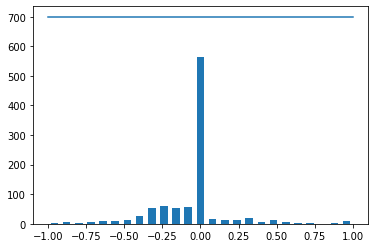

In [10]:
num_bins=25
samples_per_bin=700
hist,bins=np.histogram(data['direction'],num_bins)
center=(bins[:-1]+bins[1:])*0.5
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['direction']),np.max(data['direction'])),(samples_per_bin,samples_per_bin))

In [11]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

Training Samples: 771
Valid Samples: 193


Text(0.5, 1.0, 'Validation set')

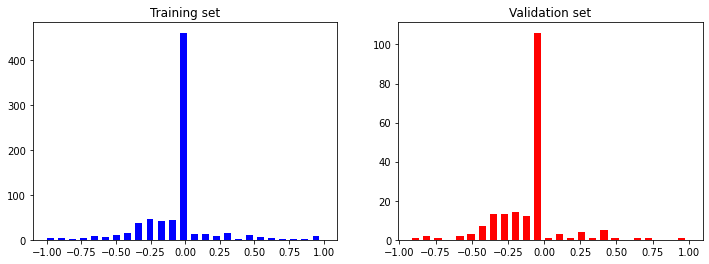

In [12]:
X_train, X_valid, Y_train, Y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=0)

print("Training Samples: {}\nValid Samples: {}".format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(Y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(Y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [13]:
def img_preprocess(img):
  img = npimg.imread(img)
  
  ## Crop image to remove unnecessary features
  img = img[60:135, :, :]
  
  ## Change to YUV image
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  
  ## Gaussian blur
  img = cv2.GaussianBlur(img, (3, 3), 0)
  
  ## Decrease size for easier processing
  img = cv2.resize(img, (100, 100))
  
  ## Normalize values
  img = img / 255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

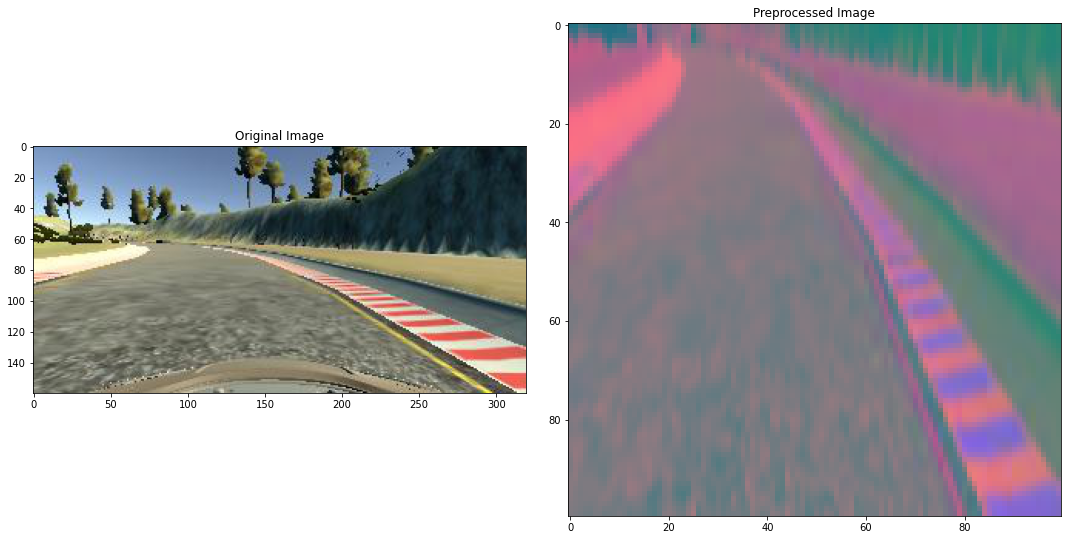

In [14]:
image = image_paths[100]
original_image = npimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')

In [15]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

In [19]:
from tensorflow.keras.applications import ResNet50
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

for layer in resnet.layers[:-4]:
    layer.trainable = False
 
for layer in resnet.layers:
    print(layer, layer.trainable)

94781440/94765736 [==============================] - 1s 0us/step
<keras.engine.input_layer.InputLayer object at 0x7fe5f5fdb7d0> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7fe5f5fdb0d0> False
<keras.layers.convolutional.Conv2D object at 0x7fe5fe13ed50> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fe5f4718310> False
<keras.layers.core.Activation object at 0x7fe5f5ff6050> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7fe5f5feb8d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fe5f0d77b90> False
<keras.layers.convolutional.Conv2D object at 0x7fe5f0d1bc10> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fe5f0d17690> False
<keras.layers.core.Activation object at 0x7fe5f0d2f250> False
<keras.layers.convolutional.Conv2D object at 0x7fe5f0d2f750> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fe5f0d39410> False
<keras.layers.core.Activation

In [20]:
def nvidia_model():
  model = Sequential()
  model.add(resnet)
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
  return model

model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               3276900   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/25
7/7 [==============================] - 36s 5s/step - loss: 28.6864 - accuracy: 0.3930 - val_loss: 1.2477 - val_accuracy: 0.5130
Epoch 2/25
7/7 [==============================] - 32s 5s/step - loss: 7.4020 - accuracy: 0.4384 - val_loss: 1.8231 - val_accuracy: 0.5130
Epoch 3/25
7/7 [==============================] - 32s 5s/step - loss: 7.2582 - accuracy: 0.4099 - val_loss: 0.6585 - val_accuracy: 0.5130
Epoch 4/25
7/7 [==============================] - 32s 5s/step - loss: 7.8376 - accuracy: 0.4176 - val_loss: 0.1376 - val_accuracy: 0.5130
Epoch 5/25
7/7 [==============================] - 32s 5s/step - loss: 6.0947 - accuracy: 0.3852 - val_loss: 3.5566 - val_accuracy: 0.0052
Epoch 6/25
7/7 [==============================] - 32s 5s/step - loss: 3.7271 - accuracy: 0.3995 - val_loss: 0.2545 - val_accuracy: 0.5130
Epoch 7/25
7/7 [==============================] - 32s 5s/step - loss: 3.4386 - accuracy: 0.4501 - val_loss: 0.1176 - val_accuracy: 0.5130
Epoch 8/25
7/7 [=================

Text(0.5, 0, 'Epoch')

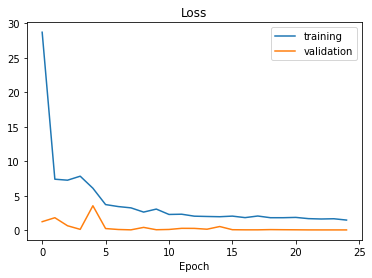

In [21]:
history = model.fit(X_train, Y_train, epochs=25, validation_data=(X_valid, Y_valid), batch_size=128, verbose=1, shuffle=1)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [22]:
y_pred = model.predict(X_valid)

In [23]:
y_pred[:5]

array([[-0.0620023 ],
       [-0.06190149],
       [-0.06165241],
       [-0.06200357],
       [-0.06164645]], dtype=float32)

In [25]:
Y_valid[:5]

array([ 0.       , -0.3989555,  0.       ,  0.       ,  0.       ])

In [26]:
score = model.evaluate(X_valid, Y_valid,verbose=1)

print(score)

7/7 [==============================] - 6s 879ms/step - loss: 0.0567 - accuracy: 0.5130
[0.05671987310051918, 0.5129533410072327]


In [27]:
from google.colab import files
model.save('model.h5')
files.download('model.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>